In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function
from skimage.transform import resize
import umap
from matplotlib.pyplot import figure


In [2]:
latent_repVIDEO  = np.load('latent_repVIDEO.npy')
latent_repWFIELD = np.load('latent_repWFIELD.npy')

len_VIDEO        = np.size(latent_repVIDEO,1)
len_WFIELD       = np.size(latent_repWFIELD,1)

mean_VIDEO       = np.mean(latent_repVIDEO,0)
mean_WFIELD      = np.mean(latent_repWFIELD,0)

std_VIDEO        = np.std(latent_repVIDEO,0)
std_WFIELD       = np.std(latent_repWFIELD,0)

pca_VIDEO        = PCA(len_VIDEO)
pca_WFIELD       = PCA(len_WFIELD)

latent_repVIDEO_normalized  = (latent_repVIDEO-mean_VIDEO)/std_VIDEO
latent_repWFIELD_normalized = (latent_repWFIELD-mean_WFIELD)/std_WFIELD

In [3]:
np.shape(latent_repVIDEO_normalized)

(7800, 32)

For latent traversal I am following these steps:
1. Input the latent vectors z,z' corresponding to each datapoint in the test set(~7800 points)
2. I have two matrics: Z:(7800,32), Z':(7800,16)
3. Center the latent vectors by subtracting out the mean
4. Perform PCA on Z to get the PCvectors. Store the first PCvector in PC1
5. Choose a random point(say 1st) in latent space say, z_0 and move it to z_0+alpha*PC1. Keep all other points the same
6. Find E(z'|z) sampled from the posterior


In [3]:
mu1_VIDEO   = np.load('mu1_VIDEO.npy')
mu2_WFIELD  = np.load('mu2_WFIELD.npy')
var1_VIDEO  = np.load('var1_VIDEO.npy')
var2_WFIELD = np.load('var2_WFIELD.npy')

In [4]:
class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size,use_mse_loss=True):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.use_mse_loss = use_mse_loss
        
        ## Encoder set1(VIDEO)
        # input size: 1x1 x 160 x 120
        self.set1_enc1 = nn.Conv2d(in_channels=1, out_channels=latent_dim1, kernel_size=4, stride=2, padding=1)
        self.set1_enc2 = nn.Conv2d(in_channels=latent_dim1, out_channels=latent_dim1, kernel_size=4, stride=2, padding=1)
        self.set1_enc3 = nn.Conv2d(in_channels=latent_dim1, out_channels=latent_dim1, kernel_size=8, stride=2, padding=1)
        self.set1_enc_for_mu = nn.Conv2d(in_channels=latent_dim1, out_channels=latent_dim1, kernel_size=(18, 13), stride=(2, 2), padding=0)
        self.set1_enc_for_sigma = nn.Conv2d(in_channels=latent_dim1, out_channels=latent_dim1, kernel_size=(18, 13), stride=(2, 2), padding=0)
        self.set1_flatten = nn.Flatten()
        ## Decoder set1(VIDEO)
        # input size: 32x1x1
        self.set1_dec0 = nn.ConvTranspose2d(in_channels=latent_dim1, out_channels=latent_dim1, kernel_size=(18, 13), stride=2, padding=0)
        self.set1_dec1 = nn.ConvTranspose2d(in_channels=latent_dim1, out_channels=latent_dim1, kernel_size=8, stride=2, padding=1)
        self.set1_dec2 = nn.ConvTranspose2d(in_channels=latent_dim1, out_channels=latent_dim1, kernel_size=4, stride=2, padding=1)
        self.set1_dec3 = nn.ConvTranspose2d(in_channels=latent_dim1, out_channels=1, kernel_size=4, stride=2, padding=1)        
        
        ## Encoder set2(WFIELD)
        # input size: 1x 1 x 135 x 160
        self.set2_enc1 = nn.Conv2d(in_channels=1, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 1x16 x 67 x 80
        self.set2_enc2 = nn.Conv2d(in_channels=latent_dim2, out_channels=latent_dim2, kernel_size=4, stride=2, padding=1)
        # size: 1x16 x 33 x 40
        self.set2_enc3 = nn.Conv2d(in_channels=latent_dim2, out_channels=latent_dim2, kernel_size=10, stride=(6, 8), padding=1)
        # size: 16 x 5 x 5   
        ## Decoder set2(WFIELD)
        # input size: 16x1x1
        self.set2_dec0 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=latent_dim2, kernel_size=5, stride=2, padding=0)
        # input size: 16x5x5
        self.set2_dec1 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=latent_dim2, kernel_size=10, stride=(6,8), padding=1,output_padding=(1,0))
        # size: 16 x 33 x 40
        self.set2_dec2 = nn.ConvTranspose2d(in_channels=latent_dim2,out_channels=1, kernel_size=6, stride=4, padding=1,output_padding=(3,0))
        # size: 1 x 135 x 160
        
        self.WFIELDc1 = nn.Conv2d(latent_dim2, latent_dim2, 4, 2, 0)
        # size: 16 x 1 x 1
        self.WFIELDc2 = nn.Conv2d(latent_dim2, latent_dim2, 4, 2, 0)
        # size: 16 x 1 x 1
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.flag_initialize = 1
        self.g12 = torch.zeros(latent_dim1,latent_dim2).to(device)     
    def forward(self,data1,data2):
        data1 = data1.unsqueeze(2)
        data1 = data1.unsqueeze(3)
        data2 = data2.unsqueeze(2)
        data2 = data2.unsqueeze(3)
        # decoding for VIDEO
        x1 = F.relu(self.set1_dec0(data1))
        x1 = F.relu(self.set1_dec1(x1))
        x1 = F.relu(self.set1_dec2(x1))
        # decoding for WFIELD
        x2 = F.relu(self.set2_dec0(data2))
        x2 = F.relu(self.set2_dec1(x2))
        reconstruction1 = self.set1_dec3(x1).view(-1,dim_VIDEO)
        reconstruction2 = self.set2_dec2(x2).view(-1,dim_WFIELD)
        return reconstruction1,reconstruction2

In [5]:
PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VIDEO_WFIELD_NEW/video_wfield_new.txt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
state = torch.load(PATH)
latent_dim1 = 32
latent_dim2 = 16
batch_size  = 1
dim_VIDEO   = 19200
dim_WFIELD   = 1* 135* 160
model = VAE(latent_dim1, latent_dim2, batch_size,use_mse_loss=True).to(device)
model.load_state_dict(state['state_dict'])
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set1_enc3.weight
set1_enc3.bias
set1_enc_for_mu.weight
set1_enc_for_mu.bias
set1_enc_for_sigma.weight
set1_enc_for_sigma.bias
set1_dec0.weight
set1_dec0.bias
set1_dec1.weight
set1_dec1.bias
set1_dec2.weight
set1_dec2.bias
set1_dec3.weight
set1_dec3.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set2_enc3.weight
set2_enc3.bias
set2_dec0.weight
set2_dec0.bias
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias
WFIELDc1.weight
WFIELDc1.bias
WFIELDc2.weight
WFIELDc2.bias


For latent traversal I am following these steps:
1. Input the latent vectors z,z' corresponding to each datapoint in the test set(~7800 points)
2. I have two matrics: Z:(7800,32), Z':(7800,16)
3. Center the latent vectors by subtracting out the mean
4. Perform PCA on Z to get the PCvectors. Store the first PCvector in PC1
5. Choose a random point(say 1st) in latent space say, z_0 and move it to z_0+alpha*PC1. Keep all other points the same
6. Find E(z'|z) sampled from the posterior

In [6]:
for name, para in model.named_parameters():
    if name =='g11':
        g11_param = para.cpu().detach()
    if name =='g22':
        g22_param = -torch.exp(para).cpu().detach()
def var_calc(z,g22,lambda_2):
    val   = 2*(1-torch.matmul(torch.square(z),g22)-lambda_2)
    return torch.reciprocal(val)
def mean_calc(z,var,g11,lambda_1):
    beta = torch.matmul(z,g11)+lambda_1
    return var*beta
def value_calc(z,g11,g22,lambda_1,lambda_2):
    var1          = var_calc(z,g22,lambda_2)
    mean1         = mean_calc(z,var1,g11,lambda_1)
    out           = mean1+torch.sqrt(var1.float())*torch.randn_like(var1)
    return mean1

latent_VIDE0_pca  = pca_VIDEO.fit_transform(latent_repVIDEO_normalized)
latent_WFIELD_pca = pca_WFIELD.fit_transform(latent_repWFIELD_normalized)

In [7]:
wfield_zero = torch.zeros(1,16)

In [30]:
#alpha = np.linspace(-2, 0, num=5)
alpha = [-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2]
alpha_size = len(alpha)
index = 6000
j = np.arange(len(alpha))
rec1_all = []
rec2_all = []
z0_perturbed = []
zp0_perturbed= []
for i in alpha:
    z0 = latent_repVIDEO[index,:]+i*latent_VIDE0_pca[index,:]
    z0_perturbed.append(z0)
    z0_tensor = torch.from_numpy(z0)   #size: 32
    mu2_WFIELD_tensor = torch.from_numpy(mu2_WFIELD[index,:])
    mu2_WFIELD_tensor = mu2_WFIELD_tensor.unsqueeze(0)
    var2_WFIELD_tensor = torch.from_numpy(var2_WFIELD[index,:])
    var2_WFIELD_tensor = var2_WFIELD_tensor.unsqueeze(0)
    z0_p = value_calc(z0_tensor,g11_param,g22_param,mu2_WFIELD_tensor,var2_WFIELD_tensor).to(device)
    
    zp0_perturbed.append(z0_p.squeeze().cpu().numpy())
    z0_tensor = z0_tensor.unsqueeze(0).to(device) #size: 1x32
    
    reconstruction1,reconstruction2 = model(z0_tensor,z0_p)
    reconstruction1_reshape = reconstruction1.view(batch_size, 1, 160, 120).cpu().detach().numpy()
    reconstruction2_reshape = reconstruction2.view(batch_size, 1, 135, 160).cpu().detach().numpy()
    rec1_resized = resize(reconstruction1_reshape, (1,1,135, 160))
    rec1_img = rec1_resized[0,0,:,:]
    rec2_img = reconstruction2_reshape[0,0,:,:]
    rec1_all.append(rec1_img)
    rec2_all.append(rec2_img)
rec1_all = np.asarray(rec1_all)
rec2_all = np.asarray(rec2_all)
z0_perturbed = np.asarray(z0_perturbed)
zp0_perturbed= np.asarray(zp0_perturbed)

In [31]:
alpha_size

8

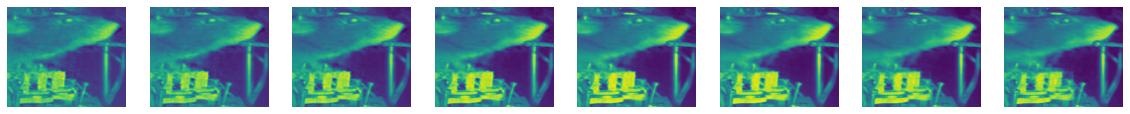

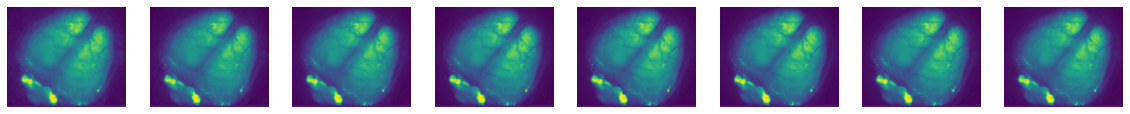

In [32]:
fig, axs = plt.subplots(1, alpha_size,figsize=(20, 20))
for i in range(alpha_size):
    axs[i].imshow(rec1_all[i,:,:])
    axs[i].axis('off')
plt.show()
fig, axs = plt.subplots(1, alpha_size,figsize=(20, 20))
for i in range(alpha_size):
    axs[i].imshow(rec2_all[i,:,:])
    axs[i].axis('off')
plt.show()

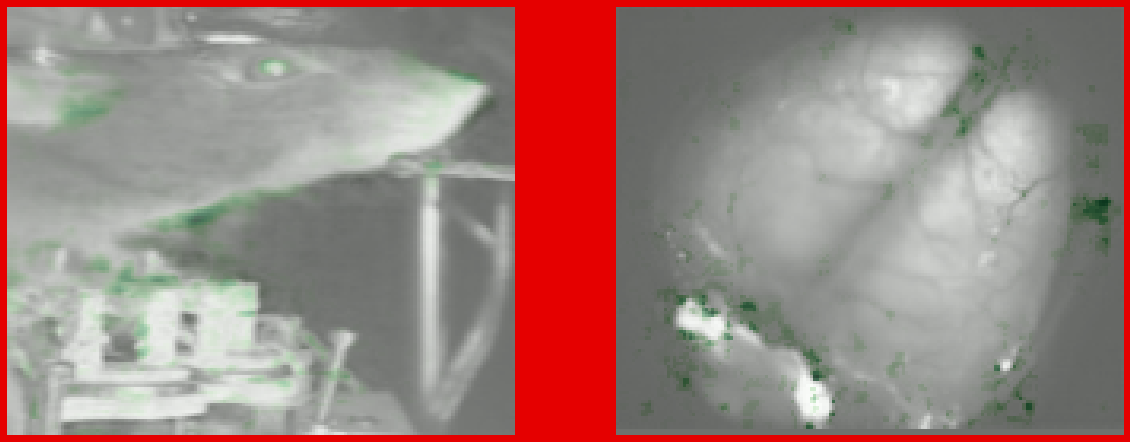

In [33]:
def small_del(rec):
    lowValY = 0.01
    low_values_flags = rec < lowValY  # Where values are low
    rec[low_values_flags] = 0  # All low values set to 0
    return rec
def diff_img(rec_all):
    res_0 =small_del(rec_all[0,:,:]- rec_all[5,:,:])
    res_1 =small_del(rec_all[1,:,:]- rec_all[5,:,:])
    res_2 =small_del(rec_all[2,:,:]- rec_all[5,:,:])
    res_3 =small_del(rec_all[3,:,:]- rec_all[5,:,:])
    res_4 =small_del(rec_all[4,:,:]- rec_all[5,:,:])
    res_5 =small_del(rec_all[5,:,:]- rec_all[5,:,:])
    res_6 =small_del(rec_all[6,:,:]- rec_all[5,:,:])
    res_7 =small_del(rec_all[7,:,:]- rec_all[5,:,:])
    res_green= res_0+2*res_1+2*res_2+2*res_3+res_4+res_5+res_6+res_7
    return res_green
cmap1 = 'blue'
cmap2 = 'green'
res1_green =diff_img(rec1_all)
res2_green =diff_img(rec2_all)
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(20, 20))
ax1.imshow(res1_green,cmap=plt.cm.Greens,alpha=1)
ax1.imshow(rec1_all[2,:,:],'gray',alpha=.6)
ax2.imshow(res2_green,cmap=plt.cm.Greens,alpha=1)
ax2.imshow(rec2_all[2,:,:],'gray',alpha=.6)
ax1.axis('off')
ax2.axis('off')
fig.patch.set_facecolor('xkcd:red')
plt.show()

In [34]:
np.save('res1_green.npy',res1_green)
np.save('rec1_all.npy',rec1_all)
np.save('res2_green.npy',res2_green)
np.save('rec2_all.npy',rec2_all)

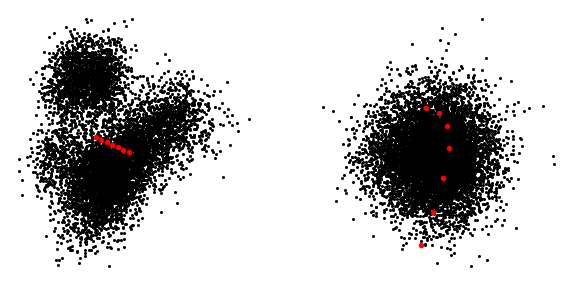

In [15]:
mean_z0 = np.mean(z0_perturbed,0)
std_z0 = np.std(z0_perturbed,0)
z0_normalized_first = (z0_perturbed-mean_z0)/std_z0
video_data_first= np.concatenate((z0_normalized_first,latent_repVIDEO_normalized),axis=0)   ## stores posterior samples ((7807, 32) datapoints)

mean_zp0 = np.mean(zp0_perturbed,0)
std_zp0 = np.std(zp0_perturbed,0)
zp0_normalized_first = (zp0_perturbed-mean_zp0)/std_zp0
wfield_data_first= np.concatenate((zp0_normalized_first,latent_repWFIELD_normalized),axis=0)   ## stores posterior samples ((7807, 16) datapoints)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10, 5))

pca_plot(video_data_first,alpha_size,ax1)
pca_plot(wfield_data_first,alpha_size,ax2)

In [14]:
def pca_plot(data,alpha_size,ax):
    pca = PCA(n_components=2)
    pca.fit(data)
    X_pca = pca.transform(data)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], cmap="Spectral", s=4,color='k')
    ax.axis('off')
    for i in range(alpha_size-1):
        ax.scatter(X_pca[i, 0], X_pca[i, 1],cmap="Spectral",  s=20, marker = 'o',color='r')
        ax.axis('off')
def pca_plot_wfield(data,alpha_size,ax):
    pca = PCA(n_components=2)
    pca.fit(data)
    X_pca = pca.transform(data)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], cmap="Spectral", s=4,color='k')
    ax.axis('off')
    for i in range(alpha_size-1):
        ax.scatter(X_pca[i, 0], X_pca[i, 1],cmap="Spectral",  s=20, marker = 'o',color='g')
        ax.axis('off')

In [16]:
# alpha = [-0.5,-0.25,0,0.5,1]
# alpha_size = len(alpha)
index = 4000
j = np.arange(len(alpha))
rec1_all = []
rec2_all = []
z0_perturbed_second = []
zp0_perturbed_second= []
for i in alpha:
    zp0 = latent_repWFIELD[index,:]+i*latent_WFIELD_pca[index,:]
    zp0_perturbed_second.append(zp0)
    zp0_tensor = torch.from_numpy(zp0)   #size: 32
    mu1_VIDEO_tensor = torch.from_numpy(mu1_VIDEO[index,:])
    mu1_VIDEO_tensor = mu1_VIDEO_tensor.unsqueeze(0)
    var1_VIDEO_tensor = torch.from_numpy(var1_VIDEO[index,:])
    var1_VIDEO_tensor = var1_VIDEO_tensor.unsqueeze(0)
    z0 = value_calc(zp0_tensor,torch.transpose(g11_param,0,1),torch.transpose(g22_param,0,1),mu1_VIDEO_tensor,var1_VIDEO_tensor).to(device)
    
    z0_perturbed_second.append(z0.squeeze().cpu().numpy())
    zp0_tensor = zp0_tensor.unsqueeze(0).to(device) #size: 1x32
    
    reconstruction1,reconstruction2 = model(z0,zp0_tensor)
    reconstruction1_reshape = reconstruction1.view(batch_size, 1, 160, 120).cpu().detach().numpy()
    reconstruction2_reshape = reconstruction2.view(batch_size, 1, 135, 160).cpu().detach().numpy()
    rec1_resized = resize(reconstruction1_reshape, (1,1,135, 160))
    rec1_img = rec1_resized[0,0,:,:]
    rec2_img = reconstruction2_reshape[0,0,:,:]
    rec1_all.append(rec1_img)
    rec2_all.append(rec2_img)
rec1_all = np.asarray(rec1_all)
rec2_all = np.asarray(rec2_all)
z0_perturbed_second = np.asarray(z0_perturbed_second)
zp0_perturbed_second= np.asarray(zp0_perturbed_second)

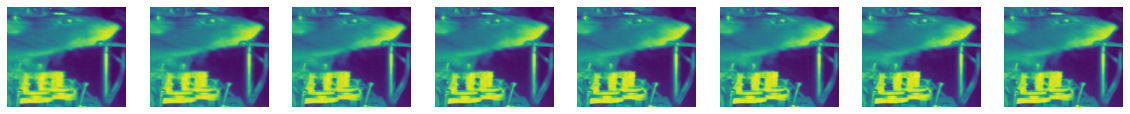

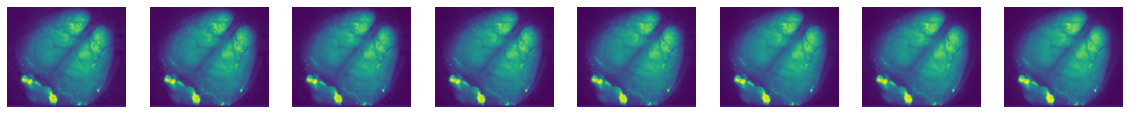

In [17]:
fig, axs = plt.subplots(1, alpha_size,figsize=(20, 20))
for i in range(alpha_size):
    axs[i].imshow(rec1_all[i,:,:])
    axs[i].axis('off')
plt.show()
fig, axs = plt.subplots(1, alpha_size,figsize=(20, 20))
for i in range(alpha_size):
    axs[i].imshow(rec2_all[i,:,:])
    axs[i].axis('off')
plt.show()

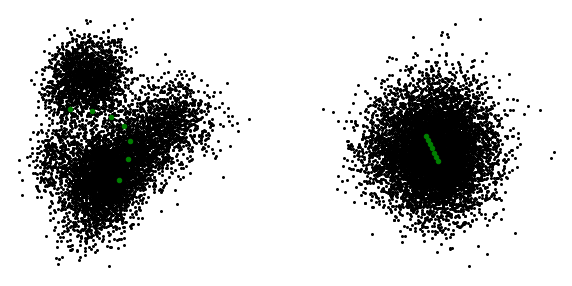

In [22]:
mean_z0 = np.mean(z0_perturbed_second,0)
std_z0 = np.std(z0_perturbed_second,0)
z0_normalized_second = (z0_perturbed_second-mean_z0)/std_z0
video_data_second= np.concatenate((z0_normalized_second,latent_repVIDEO_normalized),axis=0)   ## stores posterior samples ((7807, 32) datapoints)

mean_zp0 = np.mean(zp0_perturbed_second,0)
std_zp0 = np.std(zp0_perturbed_second,0)
zp0_normalized_second = (zp0_perturbed_second-mean_zp0)/std_zp0
wfield_data_second= np.concatenate((zp0_normalized_second,latent_repWFIELD_normalized),axis=0)   ## stores posterior samples ((7807, 16) datapoints)

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10, 5))

pca_plot_wfield(video_data_second,alpha_size,ax1)
pca_plot_wfield(wfield_data_second,alpha_size,ax2)

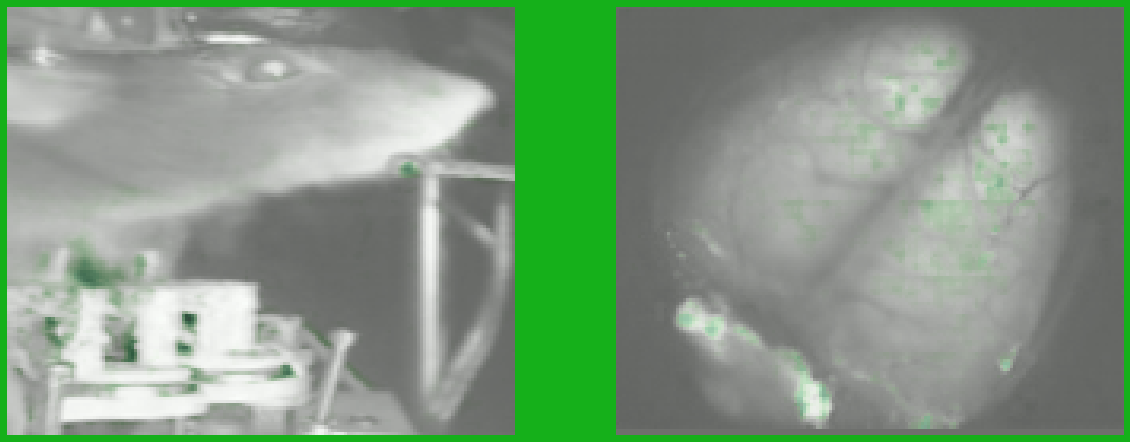

In [27]:
res1_green =diff_img(rec1_all)
res2_green =diff_img(rec2_all)
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(20, 20))
ax1.imshow(res1_green,cmap=plt.cm.Greens,alpha=1)
ax1.imshow(rec1_all[2,:,:],'gray',alpha=.6)
ax2.imshow(res2_green,cmap=plt.cm.Greens,alpha=1)
ax2.imshow(rec2_all[2,:,:],'gray',alpha=.6)
ax1.axis('off')
ax2.axis('off')
fig.patch.set_facecolor('xkcd:green')
plt.show()

In [28]:
np.save('res1_green_prime.npy',res1_green)
np.save('rec1_all_prime.npy',rec1_all)
np.save('res2_green_prime.npy',res2_green)
np.save('rec2_all_prime.npy',rec2_all)


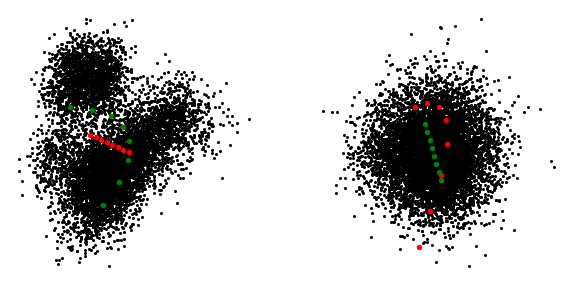

In [24]:
def pca_plot_complete(data,alpha_size,ax):
    pca = PCA(n_components=2)
    pca.fit(data)
    X_pca = pca.transform(data)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], cmap="Spectral", s=4,color='k')
    ax.axis('off')
    for i in range(0,alpha_size):
        ax.scatter(X_pca[i, 0], X_pca[i, 1],cmap="Spectral",  s=20, marker = 'o',color='r')
    for i in range(alpha_size,2*alpha_size):
        ax.scatter(X_pca[i, 0], X_pca[i, 1],cmap="Spectral",  s=20, marker = 'o',color='g')
video_data_third = np.concatenate((z0_normalized_first,video_data_second),axis=0)
wfield_data_third= np.concatenate((zp0_normalized_first,wfield_data_second),axis=0)   
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10, 5))
pca_plot_complete(video_data_third,alpha_size,ax1)
pca_plot_complete(wfield_data_third,alpha_size,ax2)


In [27]:
np.shape(video_data_third)

(7816, 32)

In [26]:
np.save('video_data_third.npy',video_data_third)
np.save('wfield_data_third.npy',wfield_data_third)